In [16]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mygrad import sliding_window_view
%matplotlib notebook

Functions from POMS_sentiment used to load existing dictionary

In [3]:
def load_sent_dict(path="sent_dict.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_sent_dict(sent_dict, path="sent_dict.txt"):
    with open(path, "wb") as f:
        pickle.dump(sent_dict, f, pickle.HIGHEST_PROTOCOL)

def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [4]:
sent_dict = load_sent_dict()

Functions from DJIA_preprocess used to load DJIA data

In [5]:
def load_djia(path="djia_ts.txt"):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_djia(ts, path="djia_ts.txt"):
    with open(path, "wb") as f:
        pickle.dump(ts, f, pickle.HIGHEST_PROTOCOL)

In [6]:
djia = load_djia()

Load in relevant part of the DJIA data for training, zscore it, and create time series for Calm and Happy

In [ ]:
train_djia = djia[130:130+98]
train_djia = (train_djia - np.mean(train_djia)) / np.std(train_djia)

In [7]:
calm = -sentiment_time_series(sent_dict, "tension") - sentiment_time_series(sent_dict, "anger")
happy = sentiment_time_series(sent_dict, "vigour") - sentiment_time_series(sent_dict, "depression")

This function creates a dataset by looking at "windows" of previous time series values. In other words, we're trying to predict a stock value on each day by looking at sentiment data in the past $N$ days. Obviously this means we can't do predictions for the first $N$ days which makes sense.

Experiment: to augment time series data with previous returns, you could attempt to pass DJIA data to this function as well as other time series.

We can then easily generate our training data using a call of this function.

In [97]:
def windowed_data(window_size, *ts_data):
    dataset = np.ndarray((len(ts_data[0]) - window_size + 1, window_size * len(ts_data)))
    
    for i, ts in enumerate(ts_data):
        dataset[:,window_size*i:window_size*(i+1)] = sliding_window_view(ts, (window_size,), 1)
    
    return dataset[:-1]

In [205]:
N = 3
x_train = windowed_data(N, calm, happy)
y_train = train_djia[N:]

This function will test any of our prediction algorithms by a simple cross validation.

In [206]:
def cross_validate_model(k, x_data, y_data, model):
    size = int(len(x_data) / k)
    
    prediction = np.zeros(y_data.shape)
        
    for i in range(k):
        x_train = np.concatenate((x_data[:i*size], x_data[(i+1)*size:]))
        y_train = np.concatenate((y_data[:i*size], y_data[(i+1)*size:]))
        
        x_test = x_data[i*size:(i+1)*size]
        y_test = y_data[i*size:(i+1)*size]
        print(len(y_train))
        prediction[i*size:(i+1)*size] = model(x_test, x_train, y_train)
        
    return prediction

Our first (very simple) prediction algorithm: linear regression

In [207]:
def linreg_prediction(A, x_train, y_train):
    factor = np.linalg.lstsq(x_train, y_train, rcond=None)[0]
    return np.matmul(A, factor)

<IPython.core.display.Javascript object>


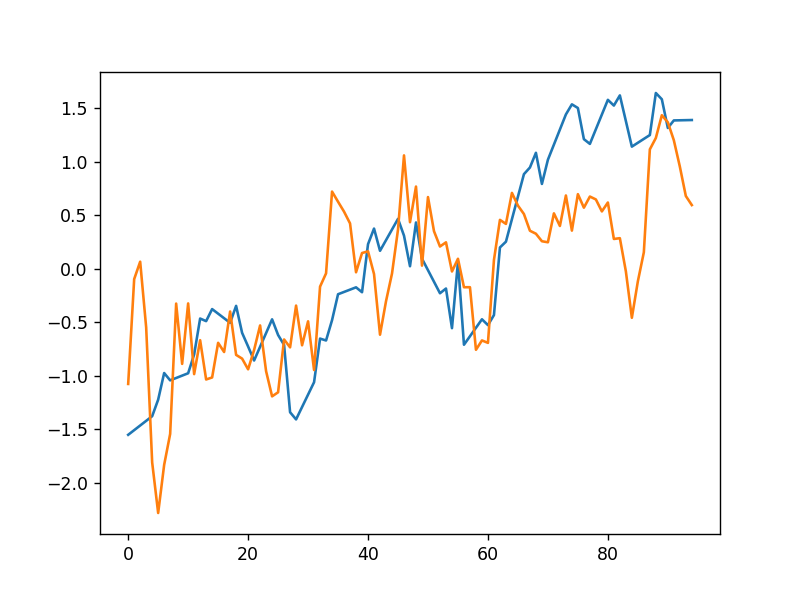

76
76
76
76
76


In [208]:
fig, ax = plt.subplots()
ax.plot(y_train)
ax.plot(cross_validate_model(5, x_train, y_train, linreg_prediction))